In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

from sklearn.metrics import (
    
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    balanced_accuracy_score, 
    classification_report,
    roc_auc_score,
    f1_score, 
    roc_curve
   
)

from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig

pd.options.mode.chained_assignment = None

with initialize(version_base=None, config_path="NCIMIPreprocessing/conf", job_name="test"):
    cfg = compose(config_name="config")
    print(OmegaConf.to_yaml(cfg))

random_seed: 0
work_dir: /work/robinpark
root_dir: ${work_dir}/NCIMIPreprocessing
raw_dicom_folder: ${work_dir}/data-apr23/PID010A
clean_path: ${work_dir}/PID010A_clean
unpaired_reports: /work/rhydian/ProcessedSpinalMRIReports/
model_weights_save_path: /scratch/shared/beegfs/robinpark
patient_metadata: ${clean_path}/patient_metadata.csv
train_labeled_data: ${clean_path}/segmented_train_manually_labeled_set.csv
labeled_data: ${clean_path}/segmented_test_manually_labeled_set.csv
no_hist_labeled_data: ${clean_path}/segmented_test_manually_labeled_set.csv



In [36]:
def norm_scores_yes(row):
    scores = torch.tensor([row['yes_score'], row['no_score']])
    return F.softmax(scores,dim=0)[0].item()

def norm_scores_no(row):
    scores = torch.tensor([row['yes_score'], row['no_score']])
    return F.softmax(scores,dim=0)[1].item()

In [37]:
li_results = []

In [38]:
def eval_global(model, desc, filepath, main_exp=True, threshold=None):

    root_path = '/work/robinpark/PID010A_clean'
    data_path = '/work/robinpark/AutoLabelClassifier/data'

    if main_exp:
        folder = f'{data_path}/report_labels'
    else:
        folder = root_path

    # Import results
    df_results = pd.read_csv(f'{folder}/{filepath}.csv', index_col=0).reset_index(drop=True)
    if 'labels' in df_results.columns:
        df_results = df_results.drop(columns=['labels'])

    if filepath.find('gpt') > -1:
        df_results.loc[df_results['results'].str.lower().str.find('uncertain') > -1, 'results'] = 0
        df_results.loc[df_results['results'].str.lower().str.find('yes') > -1, 'results'] = 1 
        df_results.loc[df_results['results'].str.lower().str.find('no') > -1, 'results'] = 0 
        df_results['results'] = df_results['results'].astype(int)

    if filepath.find('cancer') > -1:
        if filepath.find('cancer_TRAIN') > -1:
            df_true_labels = pd.read_csv(f'{root_path}/segmented_train_manually_labeled_set.csv', index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(f'{root_path}/segmented_test_manually_labeled_set.csv', index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.loc[df_results.cancer_in_image > -1]
        df_results = df_results.rename(columns={'cancer_in_image':'labels'})
        display_labels = ['No Cancer','Cancer']
    
    if filepath.find('stenosis') > -1:
        if filepath.find('stenosis_TRAIN') > -1:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/osclmric_reports_labeled_train.csv', index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/osclmric_reports_labeled_test.csv', index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.loc[df_results.result > -1]
        df_results = df_results.rename(columns={'result':'labels'})
        display_labels = ['No Stenosis','Stenosis']

    labels = df_results['labels']
    pred = df_results['results']

    roc_auc = '-'

    if model != 'gpt4':
        df_results['yes_norm'] = df_results.apply(lambda x: norm_scores_yes(x), axis=1)
        df_results['no_norm'] = df_results.apply(lambda x: norm_scores_no(x), axis=1)
        scores = df_results['yes_norm']

        if threshold:
            pred = df_results['yes_norm'] > threshold

        roc_auc = roc_auc_score(labels, scores)
        print(f'ROC AUC: {roc_auc}')

        fpr, tpr, threshold = roc_curve(labels, scores)
        fnr = 1 - tpr
        eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

        print(f'EER threshold: {eer_threshold}')
        print(f'EER: {eer}')
    
    balanced_acc = balanced_accuracy_score(labels, pred)
    print(f'Balanced accuracy: {balanced_acc}')

    f1 = f1_score(labels, pred)
    print(f'F1 score: {f1}')

    class_report = classification_report(labels, pred, target_names=display_labels)
    conf_mat = confusion_matrix(labels, pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                display_labels=display_labels)

    print(class_report)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    if desc.find('test') > -1:
        li_results.append(
            {'model': model, 'desc': desc, 
            'balanced_accuracy': balanced_acc,
            'auroc': roc_auc,
            'f1_score': f1}
        ) 
    
    return df_results

In [39]:
li_level_results = []

In [40]:
def eval_level(data, level, threshold=None): 

    label_path = '/work/robinpark/AutoLabelClassifier/data/report_labels'
    root_path = '/work/robinpark/PID010A_clean'

    display_labels = ['No Stenosis','Stenosis']

    level_rp = level.replace('-','')
    df_level = pd.read_csv(f'{label_path}/con_lora_base_2step_{data}{level_rp}_new_template_yesno_scores_have_prompt.csv')
    df_newlabels = pd.read_csv(f'{root_path}/OSCLMRIC_reports_stenosis_by_ivd.csv')

    df_results = df_level.merge(df_newlabels, left_on='report_no_hist', right_on='Report', how='left')
    df_results['labels'] = df_results[level].fillna(0)

    df_results['yes_norm'] = df_results.apply(lambda x: norm_scores_yes(x), axis=1)
    df_results['no_norm'] = df_results.apply(lambda x: norm_scores_no(x), axis=1)

    labels = df_results['labels']
    scores = df_results['yes_norm']
    pred = df_results['results']

    if threshold:
        pred = df_results['yes_norm'] > threshold
        
    roc_auc = roc_auc_score(labels, scores)
    print(f'ROC AUC: {roc_auc}')

    balanced_acc = balanced_accuracy_score(labels, pred)
    print(f'Balanced accuracy: {balanced_acc}')

    f1 = f1_score(labels, pred)
    print(f'F1 score: {f1}')

    fpr, tpr, threshold = roc_curve(labels, scores)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    test = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    print(f'EER threshold: {eer_threshold}')
    print(f'EER: {eer}')

    class_report = classification_report(labels, pred, target_names=display_labels)
    conf_mat = confusion_matrix(labels, pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                display_labels=display_labels)

    print(class_report)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    if data.find('TRAIN') > -1:
        li_level_results.append(
            {'level': level, 
            'balanced_accuracy': balanced_acc,
            'auroc': roc_auc,
            'f1_score': f1}
        ) 

    return df_results

## Global Results per Report

### GPT-4 Baseline

Balanced accuracy: 0.9498475365109934
F1 score: 0.9494163424124512
              precision    recall  f1-score   support

   No Cancer       0.88      0.99      0.93        93
      Cancer       0.99      0.91      0.95       134

    accuracy                           0.94       227
   macro avg       0.94      0.95      0.94       227
weighted avg       0.95      0.94      0.94       227



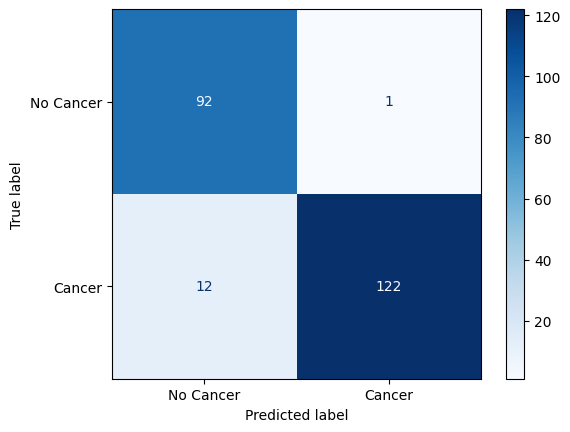

In [42]:
gpt_cancer_1step_test = eval_global(
    'gpt4', 
    '1step_cancer_test', 
    'llm_results_sep/gpt4_cancer_TRAIN_have_prompt', 
    main_exp=False, 
    threshold=None)    

Balanced accuracy: 0.9512195121951219
F1 score: 0.9487179487179488
              precision    recall  f1-score   support

 No Stenosis       0.87      1.00      0.93        27
    Stenosis       1.00      0.90      0.95        41

    accuracy                           0.94        68
   macro avg       0.94      0.95      0.94        68
weighted avg       0.95      0.94      0.94        68



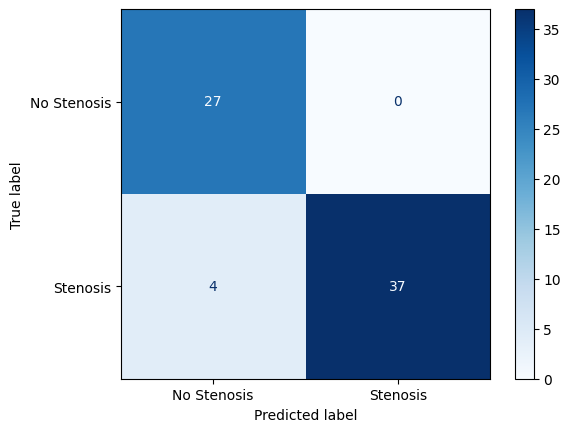

In [8]:
gpt_stenosis_1step_test = eval_global(
    'gpt4', 
    '1step_stenosis_test', 
    'llm_results_sep/gpt4_stenosis_TRAIN_new_have_prompt', 
    main_exp=False, 
    threshold=None)    

### One-Step Query

ROC AUC: 0.9864331595471959
EER threshold: 8.647349858392772e-08
EER: 0.053691275167785234
Balanced accuracy: 0.9399141630901288
F1 score: 0.9360730593607306
              precision    recall  f1-score   support

   No Cancer       0.84      1.00      0.91       149
      Cancer       1.00      0.88      0.94       233

    accuracy                           0.93       382
   macro avg       0.92      0.94      0.93       382
weighted avg       0.94      0.93      0.93       382



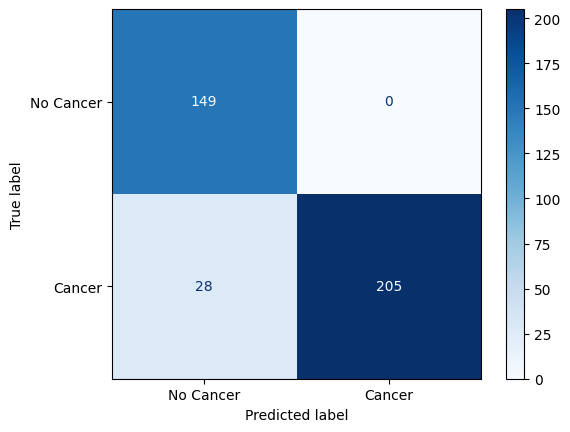

In [9]:
zephyr_1step_cancer_train = eval_global(
    'zephyr', '1step_cancer_train', 
    'base_one_step_scores/base_1step_cancer_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=None
    )

ROC AUC: 0.9772909645321778
EER threshold: 3.7830696442142653e-07
EER: 0.06451612903225806
Balanced accuracy: 0.9362461884127748
F1 score: 0.9477611940298507
              precision    recall  f1-score   support

   No Cancer       0.92      0.92      0.92        93
      Cancer       0.95      0.95      0.95       134

    accuracy                           0.94       227
   macro avg       0.94      0.94      0.94       227
weighted avg       0.94      0.94      0.94       227



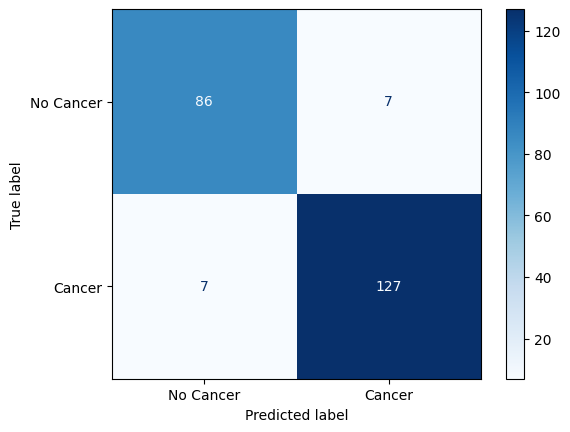

In [10]:
zephyr_1step_cancer_test = eval_global(
    'zephyr', '1step_cancer_test', 
    'base_one_step_scores/base_1step_cancer_TRAIN_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=8.647349858392772e-08
    )

ROC AUC: 0.9536231884057971
EER threshold: 6.540549293276854e-06
EER: 0.08695652173913043
Balanced accuracy: 0.8333333333333333
F1 score: 0.8
              precision    recall  f1-score   support

 No Stenosis       0.61      1.00      0.75        23
    Stenosis       1.00      0.67      0.80        45

    accuracy                           0.78        68
   macro avg       0.80      0.83      0.78        68
weighted avg       0.87      0.78      0.78        68



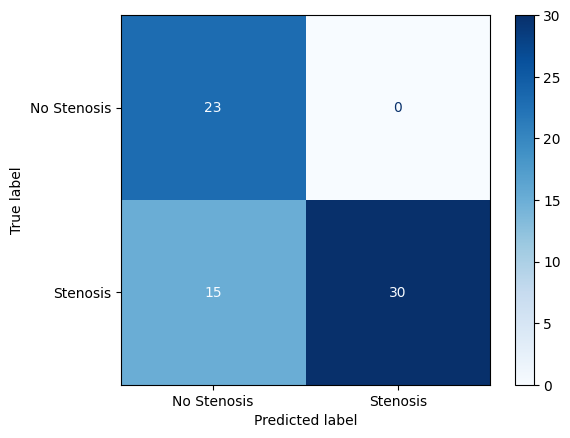

In [11]:
zephyr_1step_stenosis_train = eval_global(
    'zephyr', '1step_stenosis_train', 
    'base_one_step_scores/base_1step_stenosis_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=None
    )

ROC AUC: 0.975609756097561
EER threshold: 1.9387577765428432e-07
EER: 0.1111111111111111
Balanced accuracy: 0.9512195121951219
F1 score: 0.9487179487179488
              precision    recall  f1-score   support

 No Stenosis       0.87      1.00      0.93        27
    Stenosis       1.00      0.90      0.95        41

    accuracy                           0.94        68
   macro avg       0.94      0.95      0.94        68
weighted avg       0.95      0.94      0.94        68



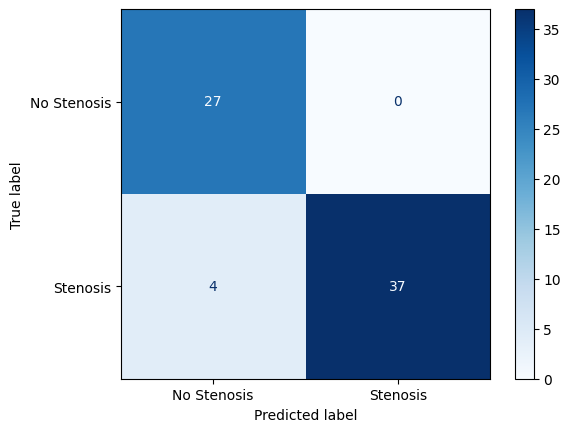

In [12]:
zephyr_1step_stenosis_test = eval_global(
    'zephyr', '1step_stenosis_test', 
    'base_one_step_scores/base_1step_stenosis_TRAIN_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=6.540549293276854e-06
    )

### Two-Step Query: Base Zephyr

ROC AUC: 0.9903505487225278
EER threshold: 5.246581835649522e-09
EER: 0.03355704697986577
Balanced accuracy: 0.9206008583690988
F1 score: 0.9137529137529137
              precision    recall  f1-score   support

   No Cancer       0.80      1.00      0.89       149
      Cancer       1.00      0.84      0.91       233

    accuracy                           0.90       382
   macro avg       0.90      0.92      0.90       382
weighted avg       0.92      0.90      0.90       382



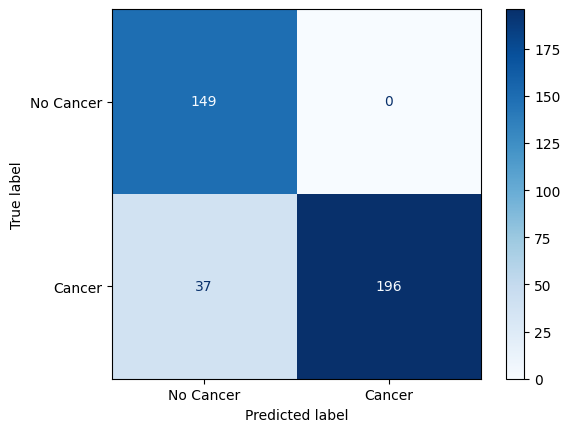

In [13]:
zephyr_2step_cancer_train = eval_global(
    'zephyr', '2step_cancer_train', 
    'base_two_step_scores/base_2step_cancer_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=None
    )

ROC AUC: 0.9805007221954742
EER threshold: 1.342980127105875e-08
EER: 0.06451612903225806
Balanced accuracy: 0.9346011876103354
F1 score: 0.9481481481481482
              precision    recall  f1-score   support

   No Cancer       0.93      0.91      0.92        93
      Cancer       0.94      0.96      0.95       134

    accuracy                           0.94       227
   macro avg       0.94      0.93      0.94       227
weighted avg       0.94      0.94      0.94       227



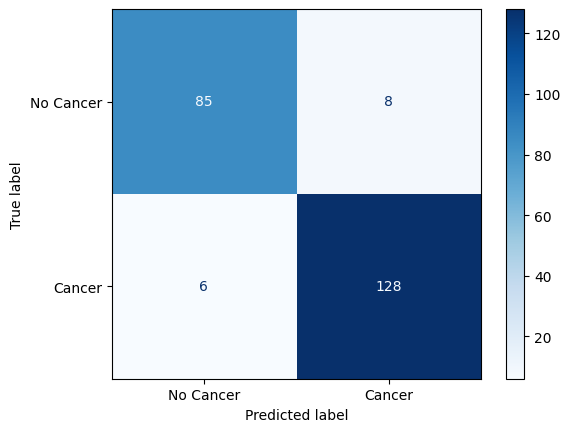

In [14]:
zephyr_2step_cancer_train = eval_global(
    'zephyr', '2step_cancer_test', 
    'base_two_step_scores/base_2step_cancer_TRAIN_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=5.246581835649522e-09
    )

ROC AUC: 0.9690821256038648
EER threshold: 6.712505182804307e-07
EER: 0.043478260869565216
Balanced accuracy: 0.8444444444444444
F1 score: 0.8157894736842105
              precision    recall  f1-score   support

 No Stenosis       0.62      1.00      0.77        23
    Stenosis       1.00      0.69      0.82        45

    accuracy                           0.79        68
   macro avg       0.81      0.84      0.79        68
weighted avg       0.87      0.79      0.80        68



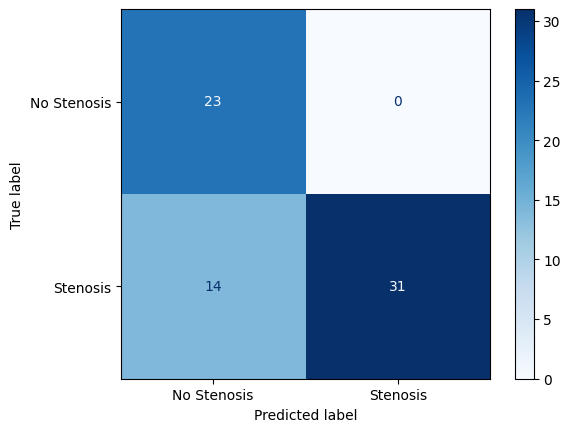

In [15]:
zephyr_2step_stenosis_train = eval_global(
    'zephyr', '2step_stenosis_train', 
    'base_two_step_scores/base_2step_stenosis_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=None
    )

ROC AUC: 0.9801264679313458
EER threshold: 2.3814553884449197e-08
EER: 0.037037037037037035
Balanced accuracy: 0.9634146341463414
F1 score: 0.9620253164556963
              precision    recall  f1-score   support

 No Stenosis       0.90      1.00      0.95        27
    Stenosis       1.00      0.93      0.96        41

    accuracy                           0.96        68
   macro avg       0.95      0.96      0.95        68
weighted avg       0.96      0.96      0.96        68



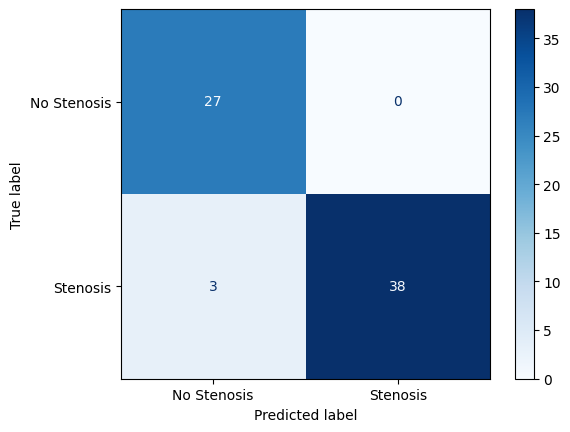

In [16]:
zephyr_2step_stenosis_test = eval_global(
    'zephyr', '2step_stenosis_test', 
    'base_two_step_scores/base_2step_stenosis_TRAIN_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=6.712505182804307e-07
    )

### Two-Step Query: Lora NTP Summary + Zephyr Query

ROC AUC: 0.9836103349943832
EER threshold: 0.0005798592464998364
EER: 0.0738255033557047
Balanced accuracy: 0.9537258403663911
F1 score: 0.953020134228188
              precision    recall  f1-score   support

   No Cancer       0.88      0.99      0.93       149
      Cancer       1.00      0.91      0.95       233

    accuracy                           0.95       382
   macro avg       0.94      0.95      0.94       382
weighted avg       0.95      0.95      0.95       382



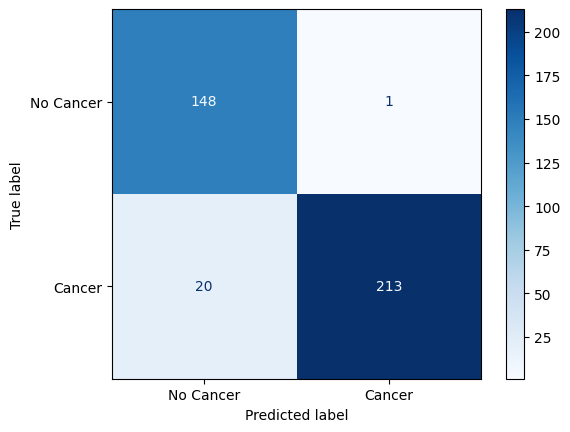

In [17]:
ntp_base_2step_cancer_train = eval_global(
    'ntp+zephyr', '2step_cancer_train', 
    'con_lora_base_2step_cancer_new_template_yesno_scores_have_prompt', 
    main_exp=True, threshold=None
    )

ROC AUC: 0.9688653506660247
EER threshold: 0.0035295409616082907
EER: 0.053763440860215055
Balanced accuracy: 0.9402985074626866
F1 score: 0.9365079365079364
              precision    recall  f1-score   support

   No Cancer       0.85      1.00      0.92        93
      Cancer       1.00      0.88      0.94       134

    accuracy                           0.93       227
   macro avg       0.93      0.94      0.93       227
weighted avg       0.94      0.93      0.93       227



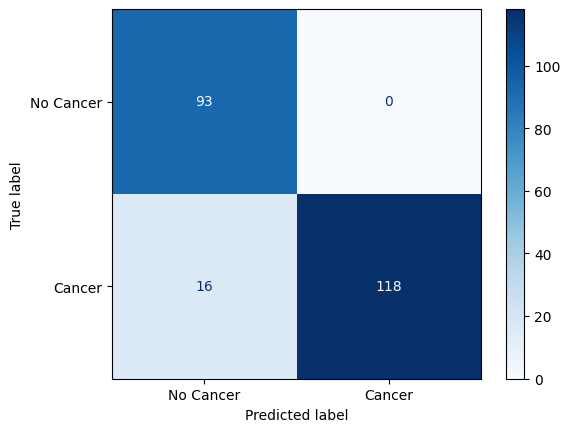

In [18]:
ntp_base_2step_cancer_test = eval_global(
    'ntp+zephyr', '2step_cancer_test', 
    'con_lora_base_2step_cancer_TRAIN_new_template_yesno_scores_have_prompt', 
    main_exp=True, threshold=None
    )

ROC AUC: 0.9893719806763285
EER threshold: 0.00017871859017759562
EER: 0.08695652173913043
Balanced accuracy: 0.8888888888888888
F1 score: 0.8750000000000001
              precision    recall  f1-score   support

 No Stenosis       0.70      1.00      0.82        23
    Stenosis       1.00      0.78      0.88        45

    accuracy                           0.85        68
   macro avg       0.85      0.89      0.85        68
weighted avg       0.90      0.85      0.86        68



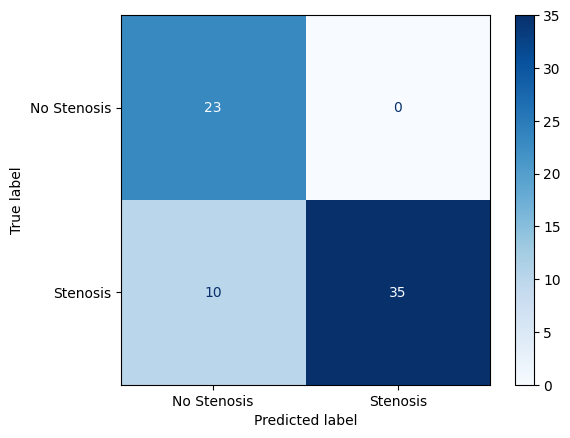

In [19]:
ntp_base_2step_stenosis_train = eval_global(
    'ntp+zephyr', '2step_stenosis_train', 
    'con_lora_base_2step_stenosis_new_template_yesno_scores_have_prompt', 
    main_exp=True, threshold=None
    )

ROC AUC: 1.0
EER threshold: 3.203858796041459e-05
EER: 0.0
Balanced accuracy: 0.975609756097561
F1 score: 0.975
              precision    recall  f1-score   support

 No Stenosis       0.93      1.00      0.96        27
    Stenosis       1.00      0.95      0.97        41

    accuracy                           0.97        68
   macro avg       0.97      0.98      0.97        68
weighted avg       0.97      0.97      0.97        68



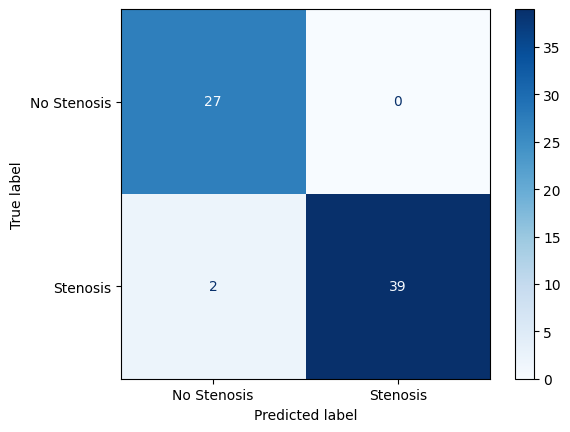

In [20]:
ntp_base_2step_stenosis_test = eval_global(
    'ntp+zephyr', '2step_stenosis_test', 
    'con_lora_base_2step_stenosis_TRAIN_new_template_yesno_scores_have_prompt', 
    main_exp=True, threshold=0.00017871859017759562
    )

### Two-Step Query: Lora NTP Summary + Query

ROC AUC: 0.9861451162254803
EER threshold: 0.00010989437578245997
EER: 0.06040268456375839
Balanced accuracy: 0.9313304721030042
F1 score: 0.9262672811059909
              precision    recall  f1-score   support

   No Cancer       0.82      1.00      0.90       149
      Cancer       1.00      0.86      0.93       233

    accuracy                           0.92       382
   macro avg       0.91      0.93      0.91       382
weighted avg       0.93      0.92      0.92       382



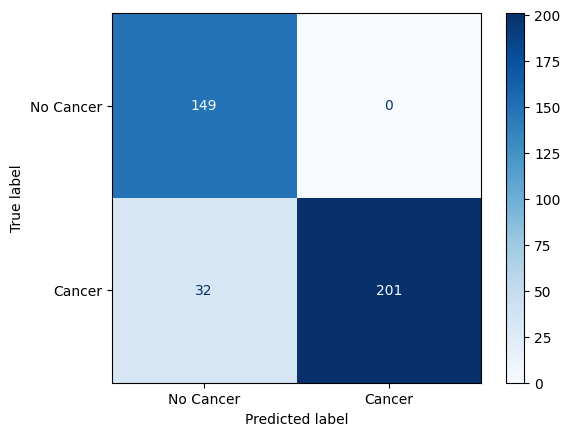

In [21]:
ntp_2step_cancer_train = eval_global(
    'ntp', '2step_cancer_train', 
    'con_lora_two_step_scores/con_lora_2step_cancer_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=None
    )

ROC AUC: 0.9717541325629915
EER threshold: 4.714190072263591e-05
EER: 0.07526881720430108
Balanced accuracy: 0.9138581287112824
F1 score: 0.9236641221374047
              precision    recall  f1-score   support

   No Cancer       0.87      0.92      0.90        93
      Cancer       0.95      0.90      0.92       134

    accuracy                           0.91       227
   macro avg       0.91      0.91      0.91       227
weighted avg       0.91      0.91      0.91       227



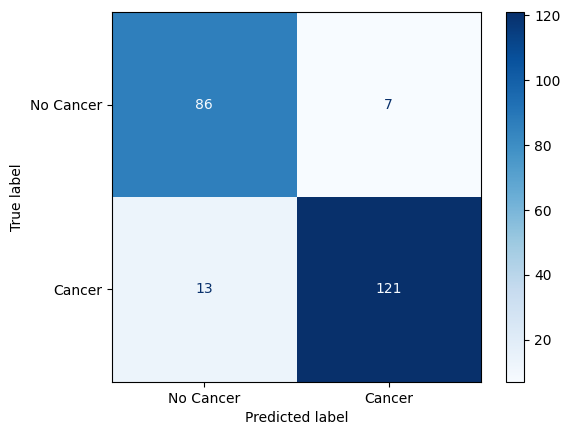

In [22]:
ntp_2step_cancer_test = eval_global(
    'ntp', '2step_cancer_test', 
    'con_lora_two_step_scores/con_lora_2step_cancer_TRAIN_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=0.00010989437578245997
    )

ROC AUC: 0.9719806763285024
EER threshold: 9.473802492721006e-05
EER: 0.08695652173913043
Balanced accuracy: 0.8111111111111111
F1 score: 0.7671232876712328
              precision    recall  f1-score   support

 No Stenosis       0.57      1.00      0.73        23
    Stenosis       1.00      0.62      0.77        45

    accuracy                           0.75        68
   macro avg       0.79      0.81      0.75        68
weighted avg       0.86      0.75      0.75        68



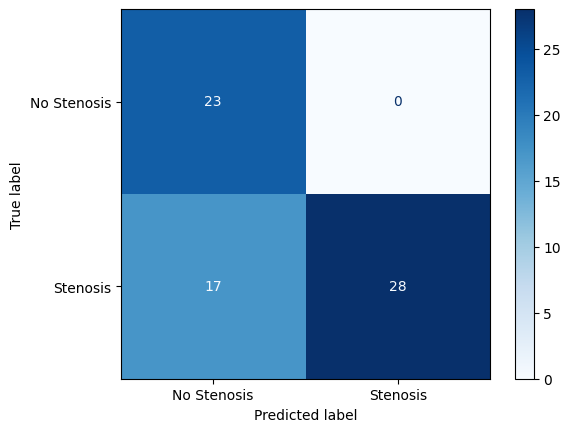

In [23]:
ntp_2step_stenosis_train = eval_global(
    'ntp', '2step_stenosis_train', 
    'con_lora_two_step_scores/con_lora_2step_stenosis_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=None
    )

ROC AUC: 0.9990966576332431
EER threshold: 1.4993872355262283e-05
EER: 0.037037037037037035
Balanced accuracy: 0.9634146341463414
F1 score: 0.9620253164556963
              precision    recall  f1-score   support

 No Stenosis       0.90      1.00      0.95        27
    Stenosis       1.00      0.93      0.96        41

    accuracy                           0.96        68
   macro avg       0.95      0.96      0.95        68
weighted avg       0.96      0.96      0.96        68



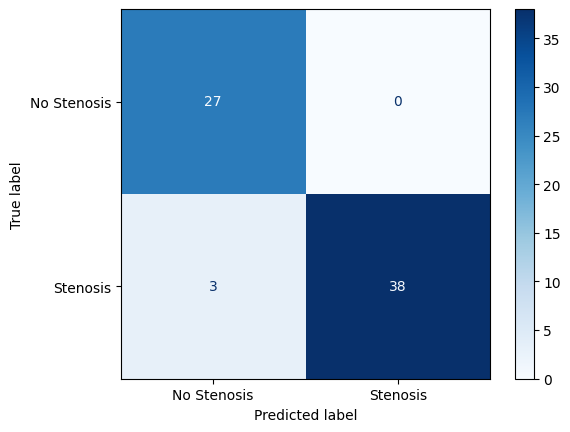

In [24]:
ntp_2step_stenosis_test = eval_global(
    'ntp', '2step_stenosis_test', 
    'con_lora_two_step_scores/con_lora_2step_stenosis_TRAIN_new_template_yesno_scores_have_prompt', 
    main_exp=False, threshold=9.473802492721006e-05
    )

In [25]:
df_results = pd.DataFrame(li_results)

In [26]:
df_results_cancer = df_results.loc[df_results.desc.str.find('cancer') > -1]
df_results_cancer

,model,desc,balanced_accuracy,auroc,f1_score
0,gpt4,1step_cancer_test,0.949848,-,0.949416
2,zephyr,1step_cancer_test,0.936246,0.977291,0.947761
4,zephyr,2step_cancer_test,0.934601,0.980501,0.948148
6,ntp+zephyr,2step_cancer_test,0.940299,0.968865,0.936508
8,ntp,2step_cancer_test,0.913858,0.971754,0.923664


In [27]:
df_results_stenosis = df_results.loc[df_results.desc.str.find('stenosis') > -1]
df_results_stenosis

,model,desc,balanced_accuracy,auroc,f1_score
1,gpt4,1step_stenosis_test,0.951220,-,0.948718
3,zephyr,1step_stenosis_test,0.951220,0.97561,0.948718
5,zephyr,2step_stenosis_test,0.963415,0.980126,0.962025
7,ntp+zephyr,2step_stenosis_test,0.975610,1.0,0.975000
9,ntp,2step_stenosis_test,0.963415,0.999097,0.962025


## IVD-Level Results for Stenosis

ROC AUC: 0.9284890426758939
Balanced accuracy: 0.696078431372549
F1 score: 0.56
EER threshold: 0.0009224715176969767
EER: 0.11764705882352941
              precision    recall  f1-score   support

 No Stenosis       0.83      0.98      0.90        51
    Stenosis       0.88      0.41      0.56        17

    accuracy                           0.84        68
   macro avg       0.85      0.70      0.73        68
weighted avg       0.84      0.84      0.82        68



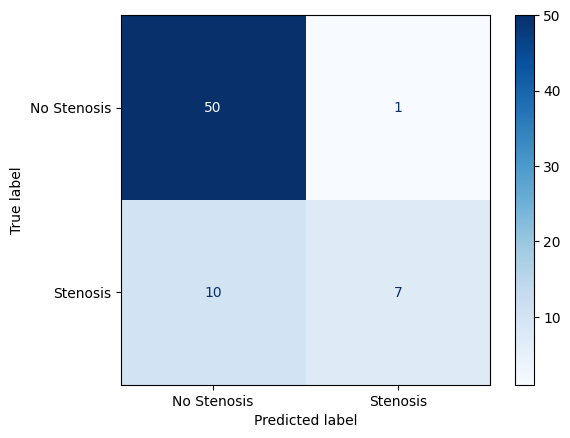

In [28]:
ntp_base_2step_stenosis_l3l4_train = eval_level('stenosis', 'L3-L4', threshold=None)

ROC AUC: 0.9188811188811189
Balanced accuracy: 0.7937062937062938
F1 score: 0.6060606060606061
EER threshold: 0.0008715130388736725
EER: 0.2
              precision    recall  f1-score   support

 No Stenosis       0.94      0.82      0.87        55
    Stenosis       0.50      0.77      0.61        13

    accuracy                           0.81        68
   macro avg       0.72      0.79      0.74        68
weighted avg       0.85      0.81      0.82        68



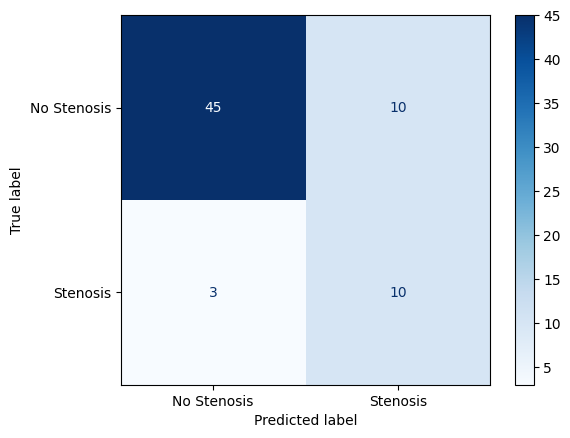

In [29]:
ntp_base_2step_stenosis_l3l4_test = eval_level('stenosis_TRAIN', 'L3-L4', threshold=0.0009224715176969767)

ROC AUC: 0.8964912280701754
Balanced accuracy: 0.7403508771929824
F1 score: 0.6666666666666667
EER threshold: 0.0009928893996402621
EER: 0.23684210526315788
              precision    recall  f1-score   support

 No Stenosis       0.72      0.95      0.82        38
    Stenosis       0.89      0.53      0.67        30

    accuracy                           0.76        68
   macro avg       0.80      0.74      0.74        68
weighted avg       0.79      0.76      0.75        68



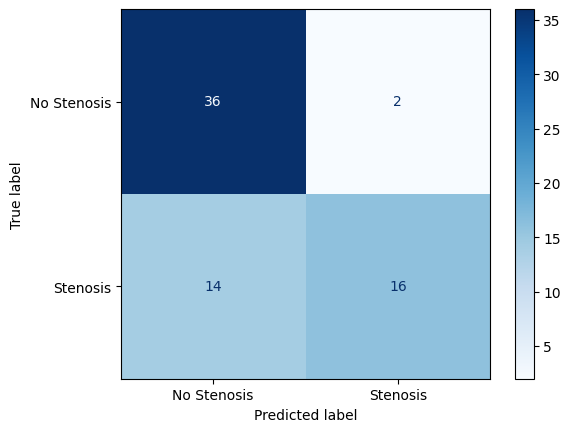

In [30]:
ntp_base_2step_stenosis_l4l5_train = eval_level('stenosis', 'L4-L5', threshold=None)

ROC AUC: 0.979947689625109
Balanced accuracy: 0.9245858761987794
F1 score: 0.9180327868852459
EER threshold: 0.0008499069954268634
EER: 0.10810810810810811
              precision    recall  f1-score   support

 No Stenosis       0.92      0.95      0.93        37
    Stenosis       0.93      0.90      0.92        31

    accuracy                           0.93        68
   macro avg       0.93      0.92      0.93        68
weighted avg       0.93      0.93      0.93        68



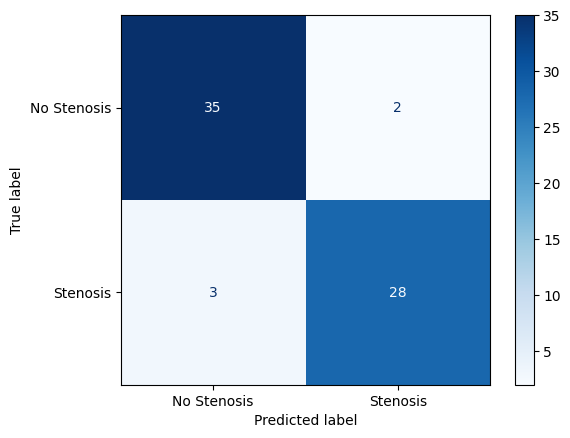

In [31]:
ntp_base_2step_stenosis_l4l5_test = eval_level('stenosis_TRAIN', 'L4-L5', threshold=0.0009928893996402621)

ROC AUC: 0.9596491228070175
Balanced accuracy: 0.8
F1 score: 0.7499999999999999
EER threshold: 0.0004927451955154538
EER: 0.13157894736842105
              precision    recall  f1-score   support

 No Stenosis       0.76      1.00      0.86        38
    Stenosis       1.00      0.60      0.75        30

    accuracy                           0.82        68
   macro avg       0.88      0.80      0.81        68
weighted avg       0.87      0.82      0.81        68



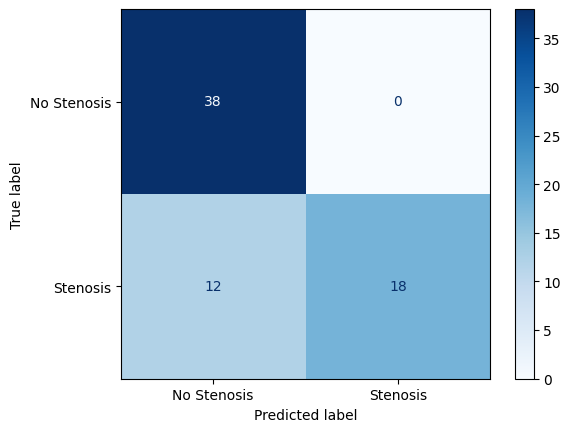

In [32]:
ntp_base_2step_stenosis_l5s1_train = eval_level('stenosis', 'L5-S1', threshold=None)

ROC AUC: 0.9732142857142858
Balanced accuracy: 0.9267857142857143
F1 score: 0.912280701754386
EER threshold: 0.0011731890263035893
EER: 0.075
              precision    recall  f1-score   support

 No Stenosis       0.95      0.93      0.94        40
    Stenosis       0.90      0.93      0.91        28

    accuracy                           0.93        68
   macro avg       0.92      0.93      0.92        68
weighted avg       0.93      0.93      0.93        68



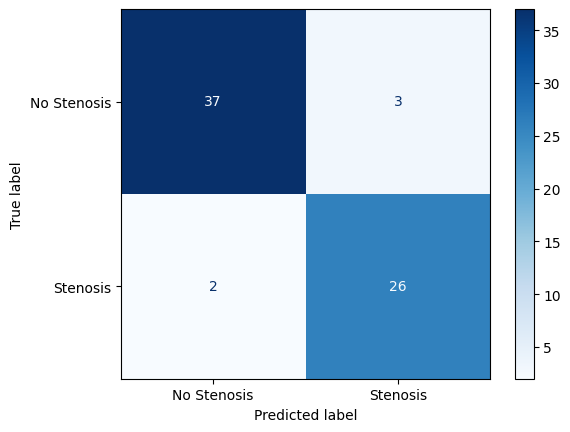

In [33]:
ntp_base_2step_stenosis_l5s1_test = eval_level('stenosis_TRAIN', 'L5-S1', threshold=0.0004927451955154538)

In [34]:
df_level_results = pd.DataFrame(li_level_results)
df_level_results

,level,balanced_accuracy,auroc,f1_score
0,L3-L4,0.793706,0.918881,0.606061
1,L4-L5,0.924586,0.979948,0.918033
2,L5-S1,0.926786,0.973214,0.912281
